In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import math
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick
from matplotlib.cm import get_cmap
# import addcopyfighandler

import seaborn as sns

from IPython.core.display import HTML

sys.path.append("../RD-systems-and-test-benches/utils")
import data_processing as dp

import model_fsolve as modf

import scipy.optimize as sco
import scipy.interpolate as sci

import simu as sim

import hx_hydraulic as hxhy
import from_excel as fe
import data_plots as dplt

import fluids as fds
from CoolProp.CoolProp import PropsSI

import openpyxl as opxl

import torch
import torch_model as modto

import ml_models as ml


In [10]:
float(ml.model_in.predict([[1,1,1]]))

C:\Users\DualSun\AppData\Local\Temp\ipykernel_6728\645313457.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(ml.model_in.predict([[1,1,1]]))


23.378537269622278

In [11]:
path = r"G:\Drive partagés\BU04-Innovation\PVT-PL-model\Inputs"
file_name = r"\V4.5_simplified.xlsx"

In [13]:
hx, par, cond = fe.initialize(path, file_name)
tabl, res, df_PL, testings = modf.PL_fsolve(par, cond, simplified=True)


c:\Users\DualSun\Documents\venvironment\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [15]:
hx, par, cond = fe.initialize(path, '\V4.5.xlsx')
tabl1, res1, df_PL1, testings1 = modf.PL_fsolve(par, cond)

In [18]:
tabl

,Pin,Pout,qx
0,320.522840,15478.207201,85.625429
1,357.113151,14542.277931,50.575025
2,346.207339,13577.003185,42.103505
3,345.919491,12596.718282,36.975095
4,346.913135,11614.494604,33.086778
5,352.345274,10639.053608,30.537199
6,353.358998,9676.300826,28.792311
7,354.048257,8730.283203,27.571404
8,370.041719,7804.502057,27.787873
9,387.499599,6899.868766,28.087848


In [19]:
tabl1

,Pin,Pout,qx
0,1092.817291,4.491703e+02,1.532136
1,1093.843543,4.491638e+02,1.532296
2,1094.867686,4.491526e+02,1.533347
3,1095.890387,4.491366e+02,1.534873
4,1096.911998,4.491158e+02,1.536671
...,...,...,...
299,1304.240743,1.669561e+01,3.006650
300,1304.287678,1.258137e+01,3.018468
301,1304.324256,8.429647e+00,3.031407
302,1304.350450,4.237596e+00,3.046297


In [14]:
res

320.52284029650286

In [9]:
from sklearn.ensemble import RandomForestRegressor

df_testings = pd.read_excel("G:\Drive partagés\BU04-Innovation\PVT-PL-model\Outputs\Tests-model-simplification\V4.5_1MPE_testings.xlsx")
X = df_testings[['QF', 'QF_out', 'alpha']].to_numpy()
yin = df_testings['DPin'].to_numpy()
yout = df_testings['DPout'].to_numpy()
yx = df_testings['DPx'].to_numpy()

model_in = RandomForestRegressor() 
model_in.fit(X, yin)

model_out = RandomForestRegressor() 
model_out.fit(X, yout)

model_x = RandomForestRegressor() 
model_x.fit(X, yx)

df_testings['DPin_test'] = model_in.predict(X)
df_testings['DPout_test'] = model_out.predict(X)
df_testings['DPx_test'] = model_x.predict(X)

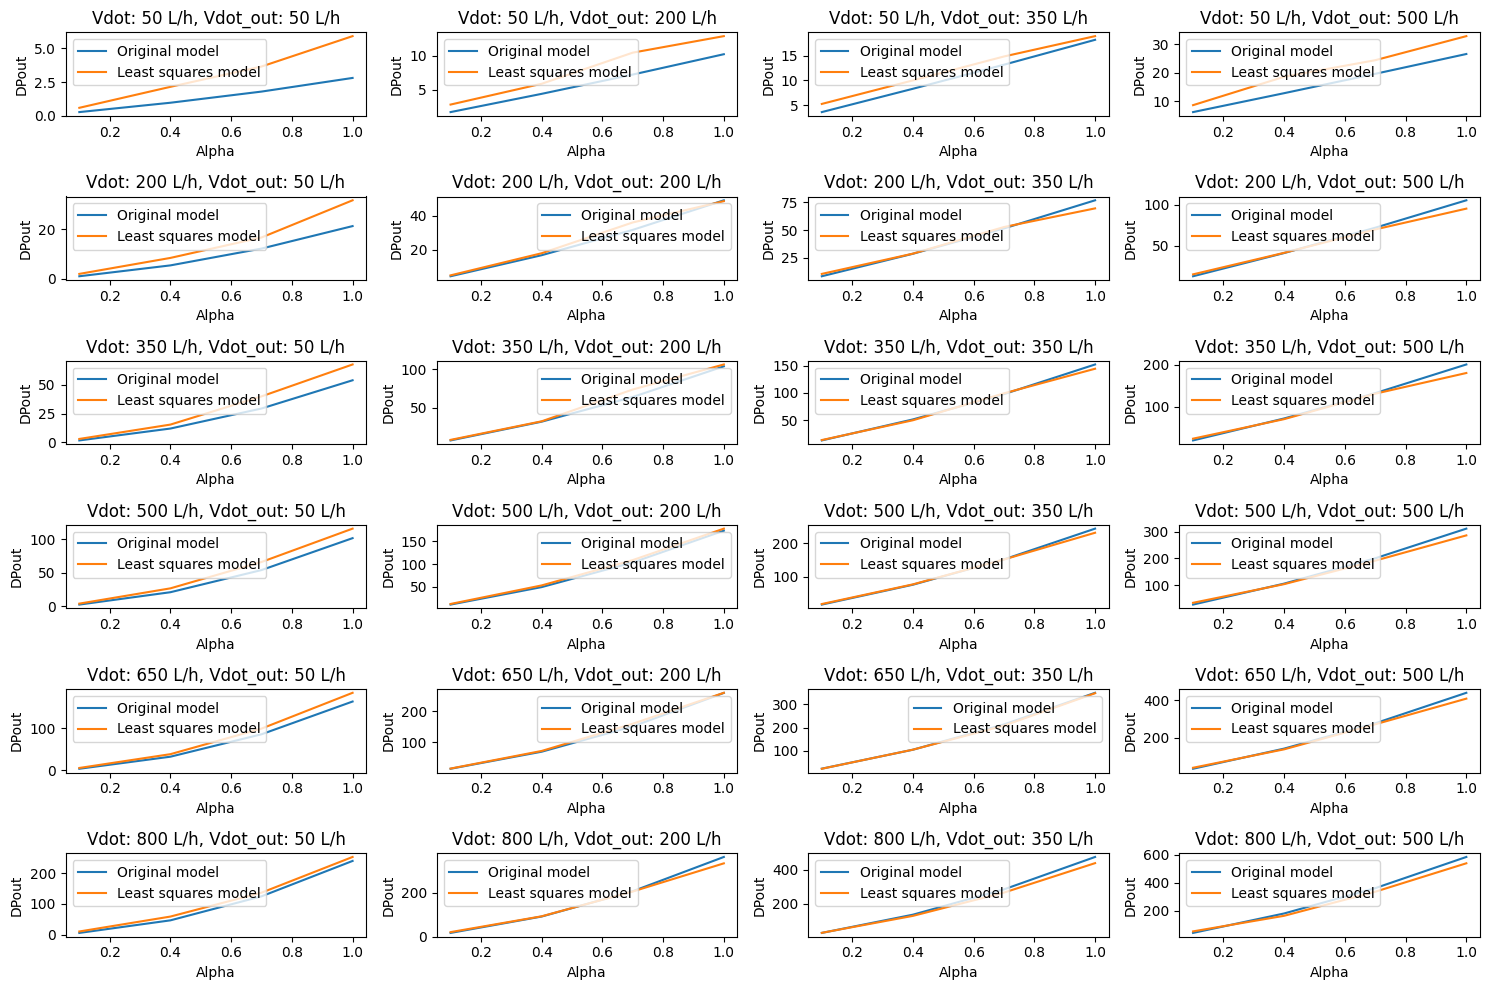

In [11]:
dplt.K_abaque(df_testings, 'DPout')

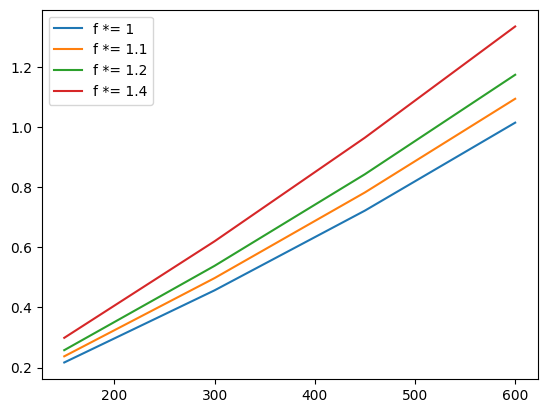

In [81]:
hx, par, cond = fe.initialize(path, file_name)
list_Vdot = np.array([150, 300, 450, 600])
list_Dv = list_Vdot/3600000
for coef in [1, 1.1, 1.2, 1.4] :
    list_PL, list_tabl = modf.PL_fsolve_range(par, cond, list_Dv, 0.25*coef)
    plt.plot(list_Vdot, list_PL/1000, label = f'f *= {coef}')
plt.legend()
plt.show()
    


In [59]:
df2 = pd.DataFrame(modf.calc(df['qx'], par, cond)).transpose()
df2.columns = ["Qin", "Qout", "uin", "ux", "uout", "Rein", "Rex", "Reout", "fin", "fx", "fout", "Kx_in", "Ky_in", "Kx_out", "Ky_out", "K_se", "Lex"]
df = df.join(df2)
df = df.join(df_PL)


ValueError: columns overlap but no suffix specified: Index(['Qin', 'Qout', 'uin', 'ux', 'uout', 'Rein', 'Rex', 'Reout', 'fin', 'fx',
       'fout', 'Kx_in', 'Ky_in', 'Kx_out', 'Ky_out', 'K_se', 'Lex'],
      dtype='object')

In [77]:
path = 'G:\Drive partagés\BU04-Innovation\PVT-PL-model\Outputs\Simulation_outputs'
path_inputs = 'G:\Drive partagés\BU04-Innovation\PVT-PL-model\Inputs'
name = '\V4.41.xlsx'
list_Vdot = np.array([150, 300, 450, 600])
hx, par, cond = fe.initialize(path_inputs, name)

writer = pd.ExcelWriter(path+name, engine = 'openpyxl')
for Vdot in list_Vdot :
    cond['Vdot'] = Vdot
    cond['Dv'] = Vdot/3600000
    df, PL, df_PL, testings = modf.PL_fsolve(par, cond)
    df2 = pd.DataFrame(modf.calc(df['qx'], par, cond)).transpose()
    df2.columns = ["Qin", "Qout", "uin", "ux", "uout", "Rein", "Rex", "Reout", "fin", "fx", "fout", "Kx_in", "Ky_in", "Kx_out", "Ky_out", "K_se", "Lex"]
    df = df.join(df2)
    df = df.join(df_PL)
    df.to_excel(writer, sheet_name= f"Vdot={Vdot}", index=False)

writer.close()


Job done


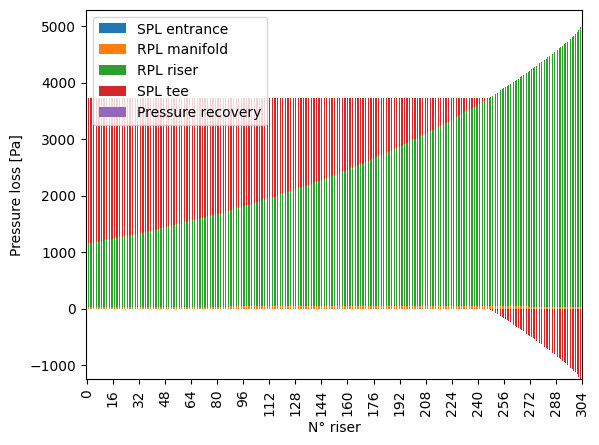

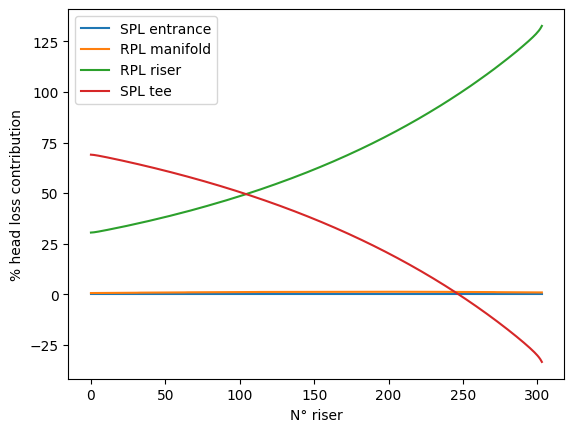

Job done
Job done
Job done


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Job done


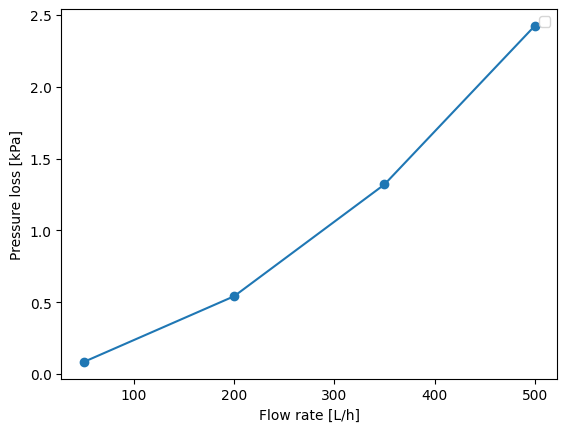

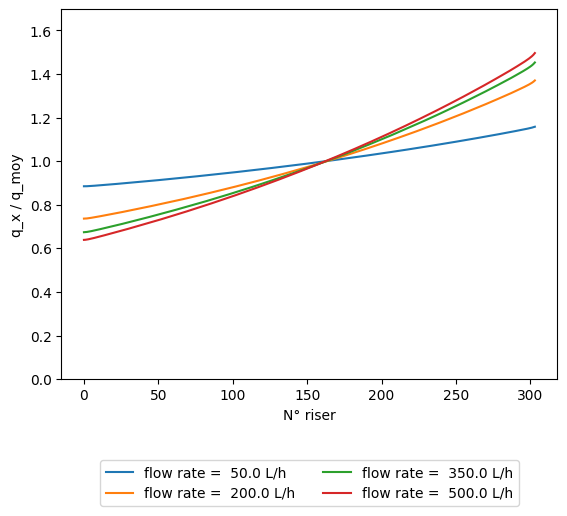

TypeError: PL_fsolve_range() missing 1 required positional argument: 'fappx'

In [228]:
dplt.solve_plot(path, file_name)

In [106]:
hx, par, cond = fe.initialize(path, file_name)

In [107]:
list_QF = np.array([50,200,350,500,650,800])/3600000
list_QF_out = np.array([50,200,350,500])/3600000
list_alpha = [0.1, 0.4, 0.7, 1]
df = fe.testing_series(r"G:\Drive partagés\BU04-Innovation\PVT-PL-model\Outputs\Tests-model-simplification\V4.5_1MPE_testings.xlsx", list_QF, list_QF_out, list_alpha, par, cond)

16

In [245]:
df_K = pd.read_excel("G:\Drive partagés\BU04-Innovation\PVT-PL-model\Outputs\Tests-model-simplification\V4.5_1MPE_testings.xlsx")

In [246]:
df_A = df_K[['QF', 'QF_out','alpha']]
df_A['constant']=1
df_A['sqrt'] = np.sqrt(df_A['QF'])
df_A['QF*alpha'] = df_A['alpha']*df_A['QF']
df_A['sqrt_alpha'] = df_A['alpha']*np.sqrt(df_A['QF'])
df_A['QF_out*alpha'] = df_A['alpha']*df_A['QF_out']
df_A['alpha2'] = df_A['alpha']**2
df_A['QF*alpha2'] = df_A['alpha2']*df_A['QF']
df_A['sqrt_alpha2'] = df_A['alpha2']*np.sqrt(df_A['QF'])
df_A['QF_out*alpha2'] = df_A['alpha2']*df_A['QF_out']
df_A = df_A[['constant', 'QF', 'sqrt', 'QF_out', 'alpha', 'QF*alpha', 'QF_out*alpha', 'sqrt_alpha', 'alpha2', 'QF*alpha2','QF_out*alpha2', 'sqrt_alpha2']]

C:\Users\DualSun\AppData\Local\Temp\ipykernel_16156\3999974192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_A['constant']=1


In [247]:
A = df_A.to_numpy()
B = df_K[['Kyin']].to_numpy()
X = np.linalg.lstsq(A,B)[0]

err = (A.dot(X)-B)*100/B
np.abs(err.round()).mean()

C:\Users\DualSun\AppData\Local\Temp\ipykernel_16156\572187708.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X = np.linalg.lstsq(A,B)[0]


41.041666666666664

In [223]:
X.transpose()*(df_A.mean().to_numpy())

array([[-3.91530645e+00, -1.48855202e+00,  3.69616417e+00,
         4.42736351e-03,  5.14293502e+00,  2.06709790e+00,
         2.94125683e-02, -5.05333466e+00, -1.99468389e+00,
        -7.93748372e-01, -9.75573375e-03,  1.94367780e+00]])

In [248]:
df = pd.DataFrame(X.transpose())
df.to_excel("G:\Drive partagés\BU04-Innovation\PVT-PL-model\Inputs\V4.5_1MPE_Kyin.xlsx", index=False)

In [249]:
df_K['Kyin_test'] = A.dot(X)

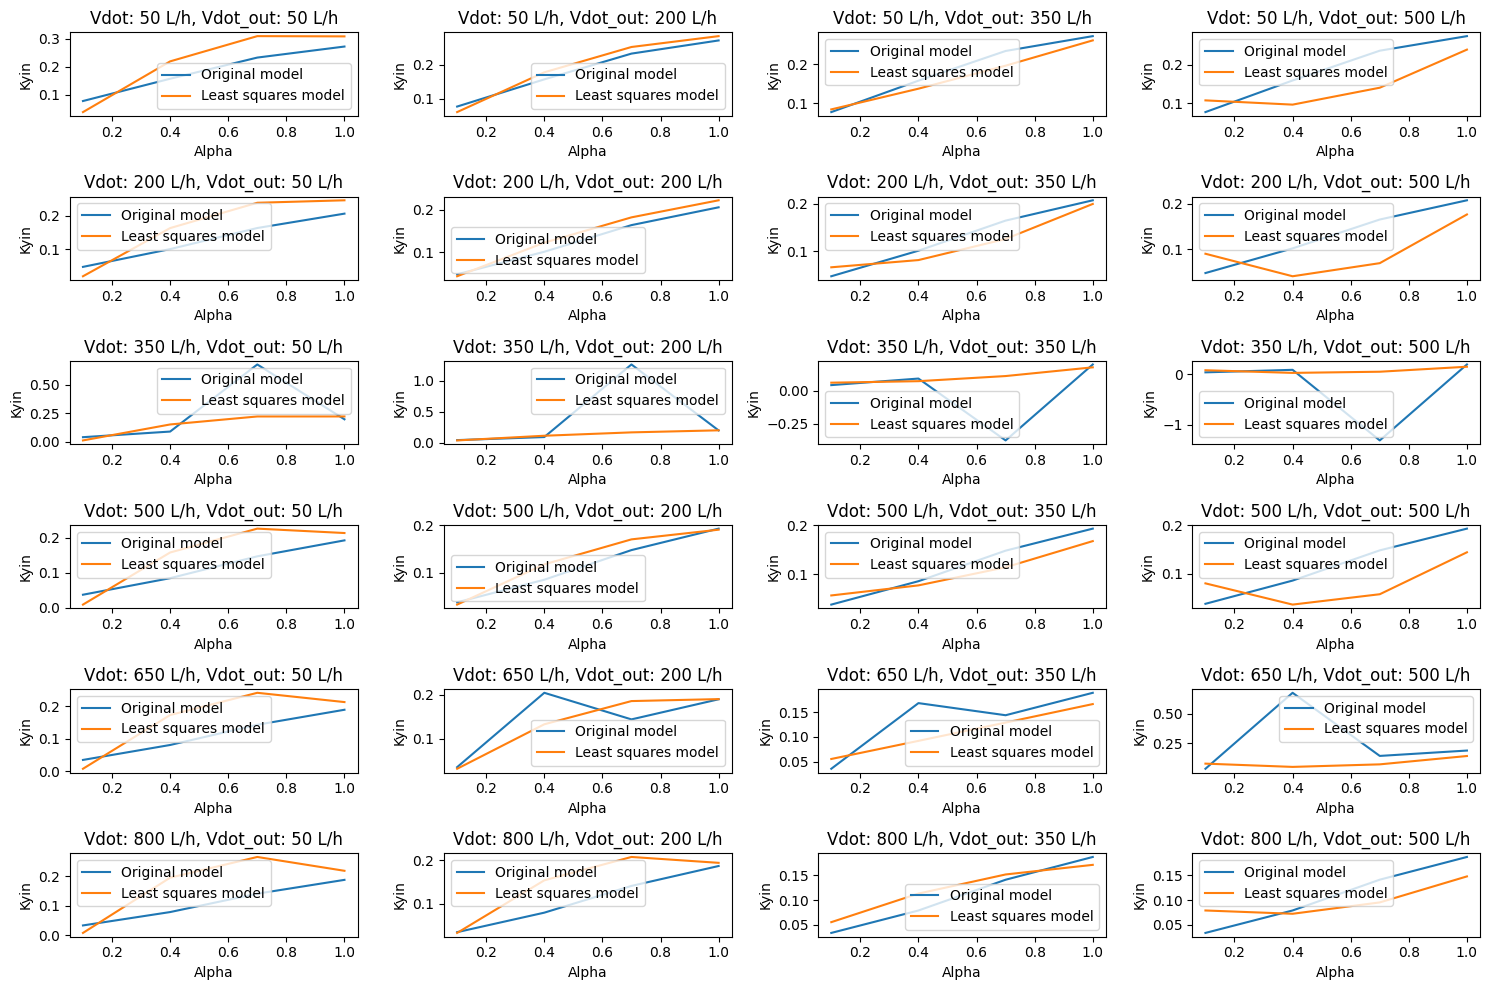

In [251]:
dplt.K_abaque(df_K,'Kyin')

In [193]:
TUV = pd.read_excel('G:\Drive partagés\BU04-Innovation\Hydraulique\PL_database\\230727_TUV_V4.41_x1_Z_water.xlsx')
path = r"G:\Drive partagés\BU04-Innovation\PVT-PL-model\Inputs"
file_name = r"\V4.41.xlsx"
hx, par, cond = fe.initialize(path, file_name)

Job done
Job done
Job done
Job done
Job done
Job done


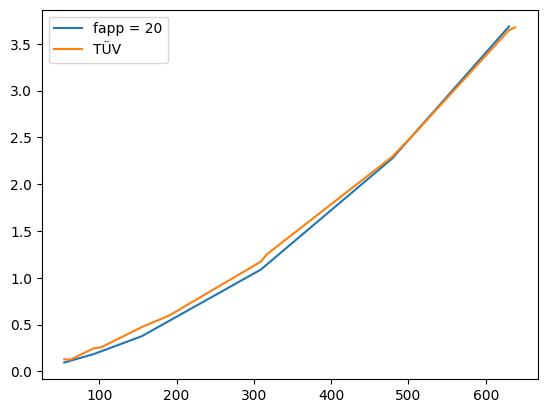

In [195]:
list_Vdot = np.array(list(TUV['Vdot']))[::2]
list_Dv = list_Vdot/3600000
f = 20
list_PL,list_tabl = modf.PL_fsolve_range(par, cond, list_Dv, f)
plt.plot(list_Vdot, list_PL/1000, label = f'fapp = {f}')
plt.plot(list(TUV['Vdot']), list(TUV['PL']), label = 'TÜV')
plt.legend()
plt.show()



In [176]:
# read excel file
excel_file = pd.ExcelFile(r'G:\Drive partagés\BU04-Innovation\Hydraulique\components\230725_PL_V4.41.xlsx')

# create dictionary with dataframes
df_dict = {}
for sheet_name in excel_file.sheet_names:
    df_dict[sheet_name] = excel_file.parse(sheet_name)
    df_dict[sheet_name].drop(columns='Unnamed: 0',inplace=True)

Job done
Job done
Job done
Job done
Job done
Job done


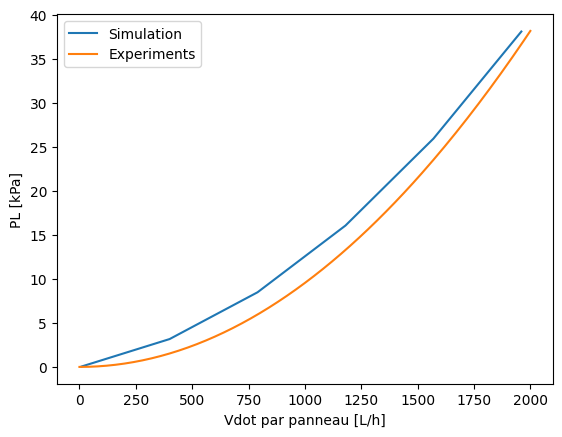

Job done
Job done
Job done
Job done
Job done
Job done


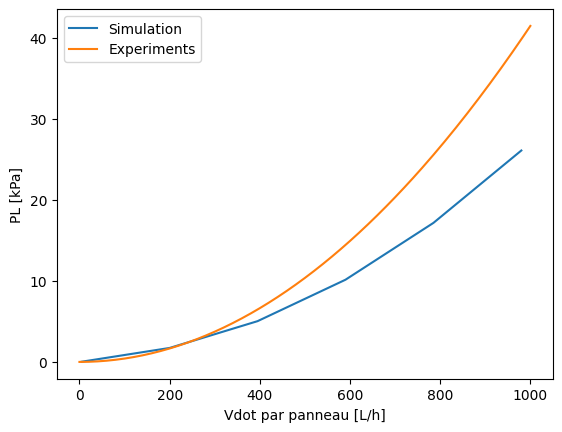

Job done
Job done
Job done
Job done
Job done
Job done


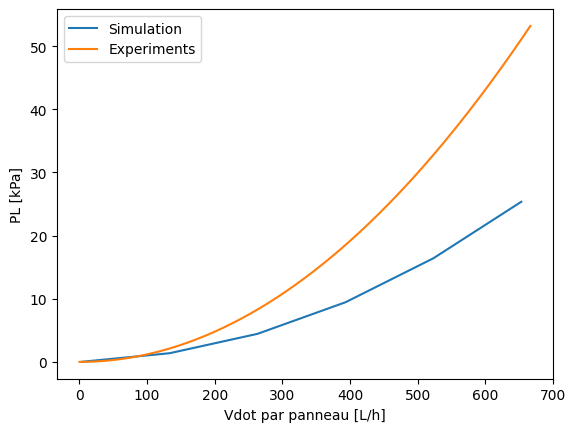

Job done
Job done
Job done
Job done


c:\Users\DualSun\Documents\venvironment\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Job done
Job done


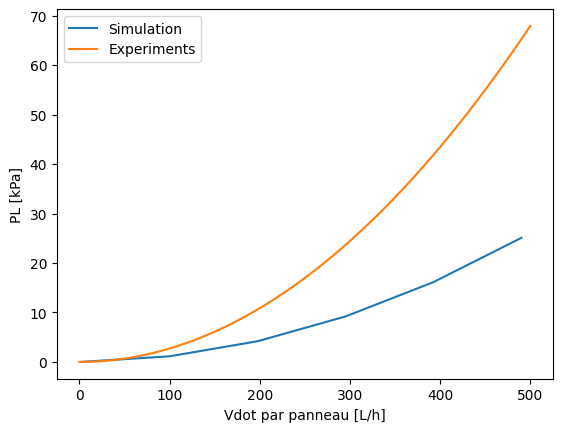

In [181]:
for i in range(4):
    key = list(df_dict.keys())[i]
    list_Vdot = np.array(df_dict[key]['Vdot_per_panel'])
    list_Dv = list_Vdot*(i+1)/3600000

    path = r"G:\Drive partagés\BU04-Innovation\PVT-PL-model\Inputs"
    file_name = f"\V4.41_x{i+1}.xlsx"
    hx, par, cond = fe.initialize(path, file_name)
    list_PL, list_tabl = modf.PL_fsolve_range(par, cond, list_Dv[1::39], 20)

    plt.plot(list_Vdot[1::39], list_PL/1000, label='Simulation')
    plt.plot(list_Vdot, np.array(df_dict[key]['PL']), label='Experiments')
    plt.xlabel('Vdot par panneau [L/h]')
    plt.ylabel('PL [kPa]')
    plt.legend()
    plt.show()



In [ ]:
list(df_dict.keys())

In [ ]:
for k in df_dict.keys():
    print(df_dict[k]['PL'])